# Custom Training with YOLOv5

In this project, we assemble a dataset and train a custom YOLOv5 model to recognize the score in our dataset. To do so we will take the following steps:

* Gather a dataset of images and label our dataset
* Export our dataset to YOLOv5
* Train YOLOv5 to recognize the objects in our dataset
* Evaluate our YOLOv5 model's performance
* Run test inference to view our model at work


#Install Requirements

In [ ]:
#clone augmentation class
!git clone https://github.com/gpurci/ImageAugmentation

Cloning into 'ImageAugmentation'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 55 (delta 27), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [ ]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow


Cloning into 'yolov5'...
remote: Enumerating objects: 14400, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 14400 (delta 14), reused 16 (delta 6), pack-reused 14371
Receiving objects: 100% (14400/14400), 13.61 MiB | 22.59 MiB/s, done.
Resolving deltas: 100% (9908/9908), done.
/content/yolov5
     |████████████████████████████████| 182 kB 14.5 MB/s 
     |████████████████████████████████| 62 kB 681 kB/s 
     |████████████████████████████████| 1.6 MB 51.2 MB/s 
     |████████████████████████████████| 42 kB 841 kB/s 
     |████████████████████████████████| 54 kB 1.0 MB/s 
     |████████████████████████████████| 145 kB 61.9 MB/s 
     |████████████████████████████████| 178 kB 54.9 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 138 kB 47.5 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 


In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Install Library

In [ ]:
import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.13.0+cu116 (Tesla T4)


In [ ]:
import re
from google.colab import files

In [ ]:
# importing cv2 
import cv2
from matplotlib import pyplot as plt
from numpy.fft import fft2, ifft2
import math
import numpy as np
import pandas as pd
import shutil
from roboflow import Roboflow

In [ ]:
#import augmentation class
from ImageAugmentation.image_augmentation import AugmentImage

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Model

In [ ]:

from livelossplot import PlotLossesKerasTF

#Calibration

In [ ]:
SIZE_ROW_IMG = 416

DECT_OBJ_IMG_WIDTH = 110
DECT_OBJ_IMG_HEIGHT = 20
DECT_OBJ_IMG_CHANNEL = 3

SCORE_DETECTION_CLASS_NAME = ['0', '1', '2', '3', '4', '5', '6', 'L']

#Functions

In [ ]:
def find_file_by_ext(path, ext):
  dict_data = {}
  for root, dirs, files in os.walk(path):
    for file in files:
      if file.endswith(ext):
        dict_data[os.path.splitext(file)[0]] = root
  return dict_data


In [ ]:
def get_lst_file_by_ext(path, ext):
  lst_filename = []
  for root, dirs, files in os.walk(path):
    for file in files:
      if file.endswith(ext):
        lst_filename.append('{}/{}'.format(root, file))
  return lst_filename


In [ ]:
def createDirectory(path):
  # checking if the directory demo_folder 
  # exist or not
  if not os.path.exists(path):
    # if the demo_folder directory is not present 
    # then create it
    os.makedirs(path)

# Assemble Dataset

In order to train our custom model, we need to assemble a dataset of representative images with bounding box annotations around the scores that we want to detect. And we need our dataset to be in YOLOv5 format.

In Roboflow, we can choose between two paths:

* Convert an existing dataset to YOLOv5 format. Roboflow supports over [30 formats object detection formats](https://roboflow.com/formats) for conversion.
* Upload raw images and annotate them in Roboflow with [Roboflow Annotate](https://docs.roboflow.com/annotate).



In [ ]:
def doAugmentedImage():
  rf = Roboflow(model_format="yolov5", notebook="ultralytics")
  #after following the link above, recieve python code with these fields filled in
  rf = Roboflow(api_key="L74r4HoRJrzqgK7mAWKk")
  # set up environment
  os.environ["DATASET_DIRECTORY"] = "/content/datasets"
  #get project digitalizare_note from roboflow
  project = rf.workspace().project("digitalizare_note")
  #get first version project
  dataset = project.version("1")
  #dowloand augmented data
  dataset = dataset.download("yolov5")
  return dataset

In [ ]:
'''try:
    shutil.rmtree('/content/yolov5/runs')
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
''' 

'try:\n    shutil.rmtree(\'/content/yolov5/runs\')\nexcept OSError as e:\n    print ("Error: %s - %s." % (e.filename, e.strerror))\n'

In [ ]:
dataset = doAugmentedImage()

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/digitalizare_note-1 in yolov5pytorch:: 100%|██████████| 46/46 [00:00<00:00, 5777.97it/s]


#Data labeling

In [ ]:
file_score = '''20201104_175012.jpg 4 0 0 4 1 0 3
20201104_175019.jpg 4 5 1 6 2 2 4
20201104_175025.jpg 4 5 1 2 2 1 3
20201104_175030.jpg 4 5 1 6 2 1 2
20201104_175035.jpg 4 0 1 2 0 0 1
20201104_175039.jpg 2 0 1 4 1 2 L
20201104_175043.jpg 2 5 0 2 0 0 L
20201104_175047.jpg 3 4 1 2 2 0 1
20201104_175053.jpg 4 0 0 4 1 2 L
20201104_175058.jpg 4 5 1 2 0 2 0
20201104_175102.jpg 4 5 0 2 1 0 4
20201104_175105.jpg 2 2 0 2 0 2 L
20201104_175130.jpg 4 0 1 6 2 2 6
20201104_175133.jpg 4 5 0 0 1 2 L
20201104_175138.jpg 4 0 1 2 0 2 L
20201104_175142.jpg 4 0 0 4 0 2 4
20201104_175148.jpg 4 4 1 2 1 0 L'''

reObjScore = re.compile(r"(?P<filename>\S+)\.jpg(?P<score>(\s+(\S+))+)")
def getScore():
  dict_score = {}
  for line in file_score.split('\n'):
    reScore = reObjScore.match(line)
    dict_score[reScore.group('filename')] = reScore.group('score').strip().split(' ')
  return dict_score

In [ ]:
reObjLabel = re.compile(r"(?P<label>\S+) (?P<center_x>\S+) (?P<center_y>\S+) (?P<w>\S+) (?P<h>\S+)")
def readLabels(filename, width, height):
  f = open(filename, "r")
  lst_x0 = []
  lst_y0 = []
  lst_x1 = []
  lst_y1 = []
  for line in f:
    reLabel = reObjLabel.match(line)
    center_x = int(float(reLabel.group('center_x'))*width)
    center_y = int(float(reLabel.group('center_y'))*height)
    w = int(float(reLabel.group('w'))*width)
    h = int(float(reLabel.group('h'))*height)
    x = int(center_x - w/2)
    y = int(center_y - h/2)
    lst_x0.append(x)
    lst_y0.append(y)
    lst_x1.append(x + w)
    lst_y1.append(y + h)
  f.close()
  return lst_x0, lst_y0, lst_x1, lst_y1


In [ ]:
def findIndex(lst_file, filename):
  for file in lst_file:
    if (file in filename) == True:
      return file
  return 'UNK'

In [ ]:
def getLabels(path):
  dict_score = getScore()
  lst_score_file = list(dict_score.keys())
  dict_data = find_file_by_ext(path, '.txt')
  dict_obj_classified = {}
  for key in dict_data:
    filename = '{}/{}.{}'.format(dict_data[key], key, 'txt')
    key_score = findIndex(lst_score_file, key)
    lst_x0, lst_y0, lst_x1, lst_y1 = readLabels(filename, width=416, height=416)
    dict_obj_classified[key_score] = {'score': dict_score[key_score], 'x0': lst_x0, 'y0': lst_y0, 'x1': lst_x1, 'y1': lst_y1}
  return dict_obj_classified



In [ ]:
def getUniqueScore():
  lst_score = []
  dict_score = getScore()
  for key in dict_score:
    lst_score.extend(dict_score[key])

  unique_score = np.unique(np.array(lst_score))
  return unique_score

In [ ]:

path = "/content/datasets/digitalizare_note-1/train"
dict_obj_classified_train = getLabels(path)

In [ ]:

path = "/content/datasets/digitalizare_note-1/test"
dict_obj_classified_test = getLabels(path)

In [ ]:

path = "/content/datasets/digitalizare_note-1/valid"
dict_obj_classified_valid = getLabels(path)

#Image augmentation

In [ ]:
aug_img  = AugmentImage()
aug_img.setRotationAngel(-5., 5.)

In [ ]:

def roboflow_data_augmentation(path, nbr_gen_for_sample):
  dict_data_f = find_file_by_ext(path, '.jpg')
  dict_data_t = find_file_by_ext(path, '.txt')
  pd_df_data = pd.DataFrame({'F':dict_data_f, 'T':dict_data_t})
  
  size_ = pd_df_data.shape[0]
  for i in range(size_):
    for j in range(i*nbr_gen_for_sample, (i+1)*nbr_gen_for_sample):
      name_ = pd_df_data.index[i].split('.')[0]

      src_t = '{}/{}{}'.format(pd_df_data['T'][i], pd_df_data.index[i], '.txt')
      dst_t = '{}/{}_gen_{}{}'.format(pd_df_data['T'][i], name_, j, '.txt')

      src_f = '{}/{}{}'.format(pd_df_data['F'][i], pd_df_data.index[i], '.jpg')
      dst_f = '{}/{}_gen_{}{}'.format(pd_df_data['F'][i], name_, j, '.jpg')
      #print('Target  src {}\nTarget  dst {}'.format(src_t, dst_t))
      #print('Feature src {}\nFeature dst {}'.format(src_f, dst_f))
      lst_generated_file.append(dst_t)
      lst_generated_file.append(dst_f)
      shutil.copy(src_t, dst_t)
      np_img = np.array(cv2.imread(src_f, cv2.IMREAD_COLOR))
      idx_img_gen = np.random.randint(low=0, high=3, size=1)[0]
      np_gen_img = aug_img.getAugmentFunc(idx_img_gen)(np_img)
      cv2.imwrite(dst_f, np_gen_img)


In [ ]:
lst_generated_file = []
path = "/content/datasets/digitalizare_note-1/test"
nbr_gen_for_sample = 900
roboflow_data_augmentation(path, nbr_gen_for_sample)

In [ ]:
lst_generated_file = []
path = "/content/datasets/digitalizare_note-1/train"
nbr_gen_for_sample = 3000
roboflow_data_augmentation(path, nbr_gen_for_sample)

In [ ]:
lst_generated_file = []
path = "/content/datasets/digitalizare_note-1/valid"
nbr_gen_for_sample = 900
roboflow_data_augmentation(path, nbr_gen_for_sample)

# Train YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training

In [ ]:
!python train.py --img {ROW_IMG_SIZE} --batch 16 --epochs 15 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/datasets/digitalizare_note-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-27-g454dae1 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, h

##Export weights

In [ ]:
#export model's weights for future use
files.download('./runs/train/exp/weights/best.pt')

#Score detection, clasification model

##Data generator

In [ ]:
SIZE_KEY_NAME = len('20201104_175030')

In [ ]:
def cutImage(img, dict_obj_IO, width, height):
  size_ = len(dict_obj_IO['x0'])

  lst_img = []
  for i in range(size_):
    x0 = dict_obj_IO['x0'][i]
    y0 = dict_obj_IO['y0'][i]
    x1 = dict_obj_IO['x1'][i]
    y1 = dict_obj_IO['y1'][i]
    tmp_img = img[y0:y1, x0:x1]
    tmp_img = cv2.resize(tmp_img, (width, height))
    lst_img.append(tmp_img)
  return lst_img

def imageClassification(dict_obj_classified, path, lst_filename, width, height):
  name_new_img = 0
  for filename in lst_filename:
    key_name = filename.split('/')[-1][:SIZE_KEY_NAME]
    img = cv2.imread(filename)
    lst_X = cutImage(img, dict_obj_classified[key_name], width, height)
    lst_y = dict_obj_classified[key_name]['score']

    for x, y in zip(lst_X, lst_y):
      filename_clasification = '{}/{}/{}.png'.format(path, y, name_new_img)
      cv2.imwrite(filename_clasification, x)
      name_new_img += 1

    

In [ ]:
#rm_path = '/content/datasets/clasification'
#shutil.rmtree(rm_path)

In [ ]:
unique_score = getUniqueScore()

In [ ]:
unique_score

array(['0', '1', '2', '3', '4', '5', '6', 'L'], dtype='<U1')

In [ ]:
path = '/content/datasets/digitalizare_note-1/train/images'
ext = 'jpg'
lst_filename = get_lst_file_by_ext(path, ext)
#create directory of all class name of train data
path = '/content/datasets/clasification/train'
for score_ in unique_score:
  tmp_path = '{}/{}'.format(path, score_)
  createDirectory(tmp_path)

imageClassification(dict_obj_classified_train, path, lst_filename, DECT_OBJ_IMG_WIDTH, DECT_OBJ_IMG_HEIGHT)

In [ ]:
path = '/content/datasets/digitalizare_note-1/test/images'
ext = 'jpg'
lst_filename = get_lst_file_by_ext(path, ext)
#create directory of all class name of test data
path = '/content/datasets/clasification/test'
for score_ in unique_score:
  tmp_path = '{}/{}'.format(path, score_)
  createDirectory(tmp_path)

imageClassification(dict_obj_classified_test, path, lst_filename, DECT_OBJ_IMG_WIDTH, DECT_OBJ_IMG_HEIGHT)

In [ ]:
path = '/content/datasets/digitalizare_note-1/valid/images'
ext = 'jpg'
lst_filename = get_lst_file_by_ext(path, ext)
#create directory of all class name of valid data
path = '/content/datasets/clasification/valid'
for score_ in unique_score:
  tmp_path = '{}/{}'.format(path, score_)
  createDirectory(tmp_path)

imageClassification(dict_obj_classified_valid, path, lst_filename, DECT_OBJ_IMG_WIDTH, DECT_OBJ_IMG_HEIGHT)

##Upload train and test data

In [ ]:
import pathlib

In [ ]:
train_dir = '/content/datasets/clasification/train'
train_dir = pathlib.Path(train_dir)

In [ ]:
test_dir = '/content/datasets/clasification/test'
test_dir = pathlib.Path(test_dir)

In [ ]:
image_count = len(list(train_dir.glob('*/*.png')))
print('Number of train image {}'.format(image_count))

Number of train image 231077


In [ ]:
image_count = len(list(test_dir.glob('*/*.png')))
print('Number of test image {}'.format(image_count))

Number of test image 18921


Split data in test and validation

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=12534,
  batch_size=batch_size,
  label_mode='categorical',
  color_mode='rgb')

Found 231077 files belonging to 8 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=42,
  batch_size=batch_size,
  label_mode='categorical',
  color_mode='rgb')

Found 18921 files belonging to 8 classes.


We can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names) #show all class name

['0', '1', '2', '3', '4', '5', '6', 'L']


##Build Model


### Create the model

In [ ]:
num_classes = len(class_names)

input = Input(
              shape=(DECT_OBJ_IMG_WIDTH, DECT_OBJ_IMG_HEIGHT, DECT_OBJ_IMG_CHANNEL),
              name='Input',
              dtype=np.uint8
              )
#We will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
x = layers.Rescaling(1./255, 
                     input_shape=(DECT_OBJ_IMG_WIDTH, DECT_OBJ_IMG_HEIGHT, DECT_OBJ_IMG_CHANNEL))(input)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(num_classes * 2, activation='relu')(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(num_classes, activation='softmax')(x)


In [ ]:
#create model
model = Model(input, output)

### Compile the model

We will, use the `adam` optimizer and `categorical_crossentropy` loss function.

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20, 110, 3)]      0         
                                                                 
 rescaling_3 (Rescaling)     (None, 20, 110, 3)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 110, 128)      3584      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 55, 128)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 55, 128)       147584    
                                                                 
 batch_normalization_9 (Batc  (None, 10, 55, 128)      512       
 hNormalization)                                           

### Train and visualize the model results

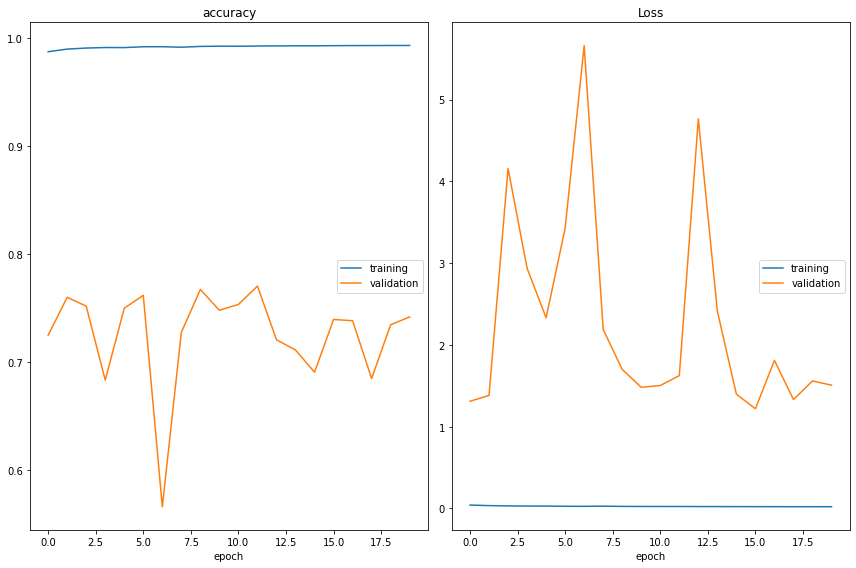

accuracy
	training         	 (min:    0.987, max:    0.993, cur:    0.993)
	validation       	 (min:    0.566, max:    0.770, cur:    0.742)
Loss
	training         	 (min:    0.021, max:    0.042, cur:    0.021)
	validation       	 (min:    1.220, max:    5.663, cur:    1.508)
23108/23108 [==============================] - 196s 8ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 1.5079 - val_accuracy: 0.7417


In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[PlotLossesKerasTF()]
)

In [ ]:
#Save model

filepath = '/content/datasets/clasification/model/score_detect_classifier'
model.save(filepath)

dir_name = '/content/datasets/clasification/model'
output_filename = '/content/datasets/clasification/model'
shutil.make_archive(output_filename, 'zip', dir_name)

#export model's weights for future use
files.download('/content/datasets/clasification/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_test.evaluate(val_ds)

1893/1893 [==============================] - 12s 6ms/step - loss: 1.5079 - accuracy: 0.7417


[1.507864236831665, 0.7417155504226685]